# Application and optimization of ARMA model in stock price prediction

In [41]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.plotting import lag_plot
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg

## Data Preparation

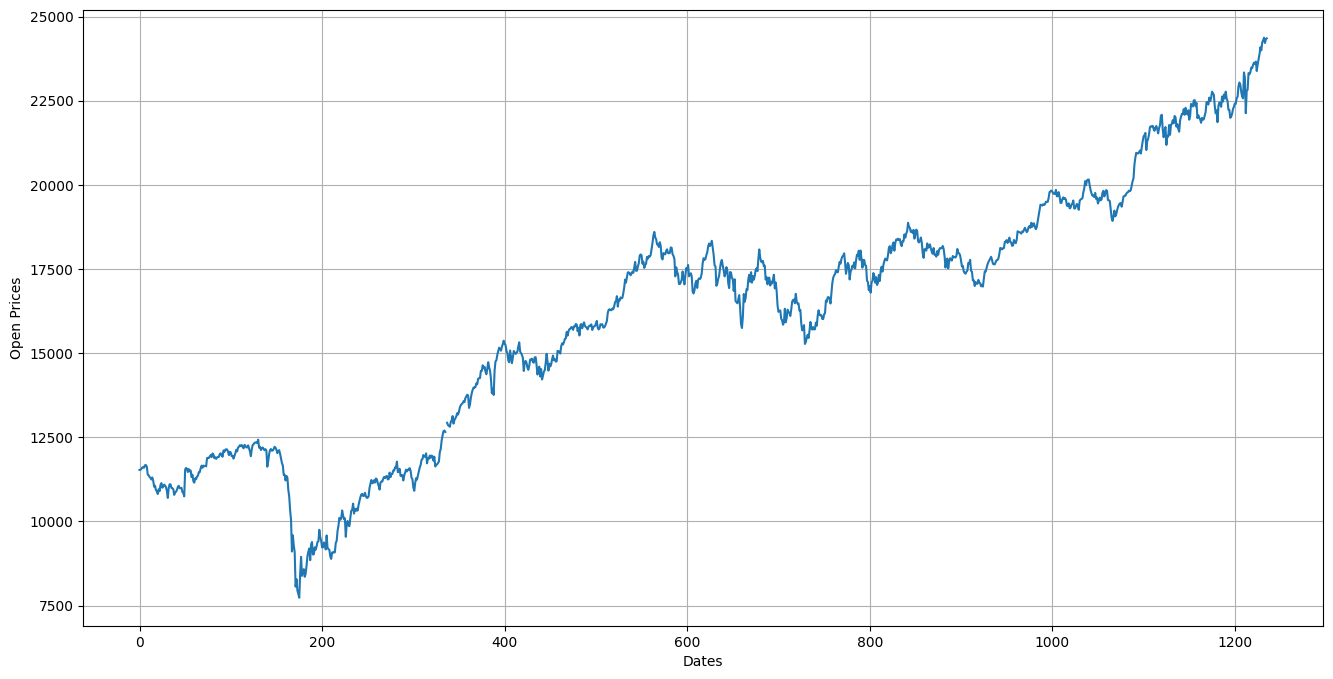

In [42]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('/home/shubham/Desktop/NIFTY-Share-Market-Price-Prediction/data/NIFTY 50.csv')
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])

In [44]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

## Autocorrelation process assumes that observation of previous several time steps are useful to predict the next step which is the correlation between the observations themselves.
## Calculate the correlation between output variables and several lagged values. AR process will get the lagged value with high correlation a greater weight in model.
## If there were low or none correlation between output variable and all the lagged values, this time-series might be unpredictable.  
## Hence before go on AR process, figuring out autocorrelation of the one-factor time series itself is necessary to do.

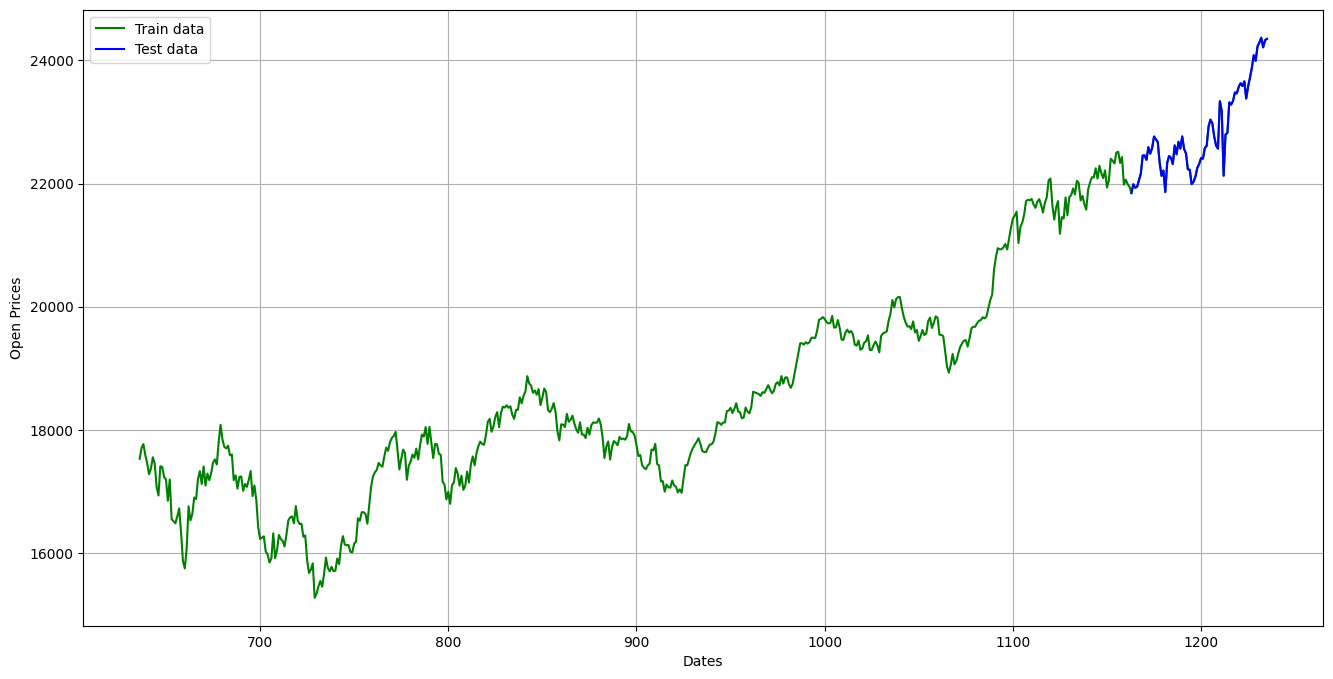

In [43]:
train_data, test_data = data[0:-73], data[-73:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()

### The charts above shows a high correlation between y(t) and y(t+5).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


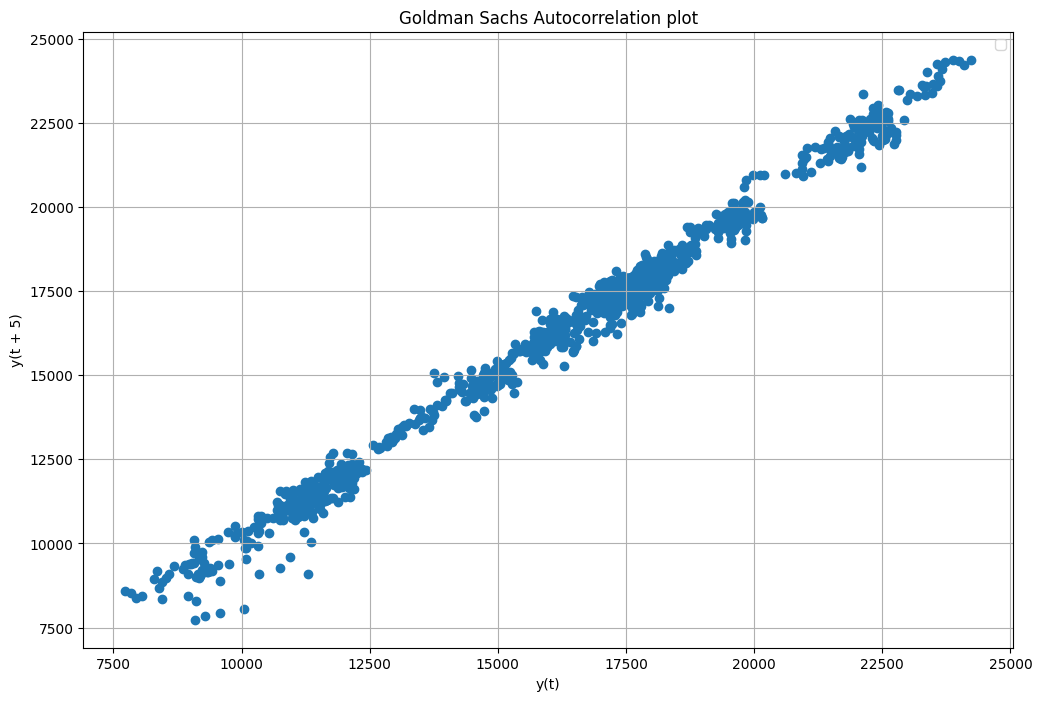

In [45]:
plt.figure(figsize=(12,8))
lag_plot(data['Open'], lag=5)
plt.title('Goldman Sachs Autocorrelation plot')
plt.grid(True)
plt.legend()

### Checking correlation by calculating covariance:

In [46]:
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.996278  0.991095  0.968576  0.998956
t+1   0.996278  1.000000  0.995162  0.973091  0.995242
t+5   0.991095  0.995162  1.000000  0.978885  0.990031
t+10  0.968576  0.973091  0.978885  1.000000  0.967477
t+30  0.998956  0.995242  0.990031  0.967477  1.000000


# AR

In [ ]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
train_data['Open'].fillna(method='ffill', inplace=True)


In [48]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# MA

/home/shubham/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


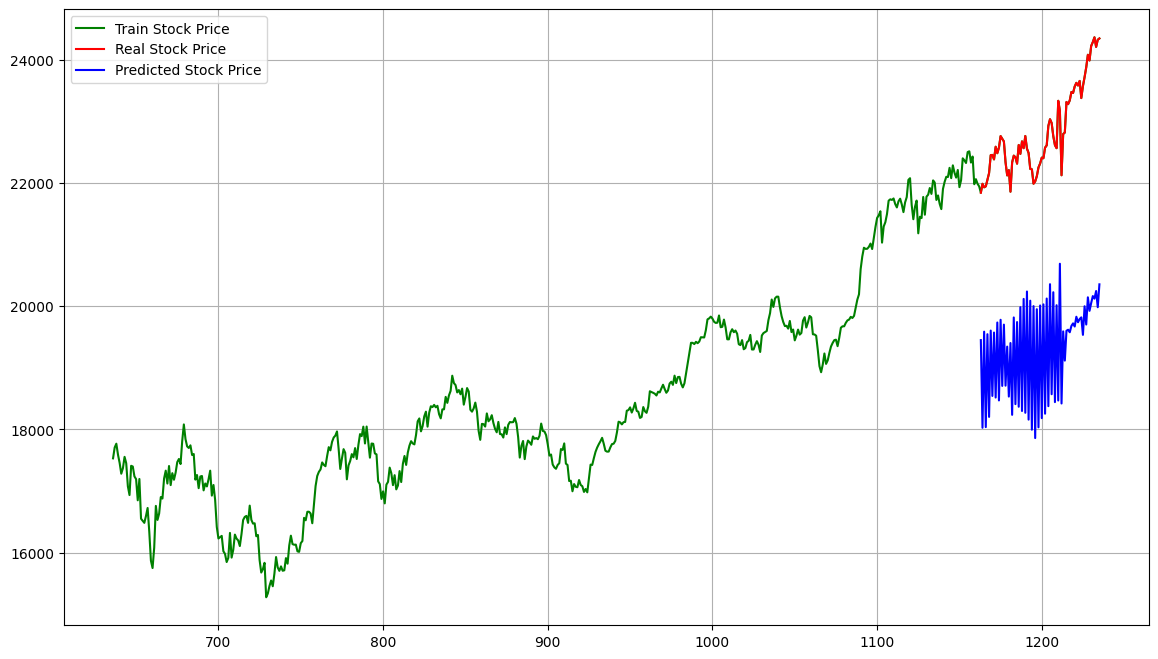

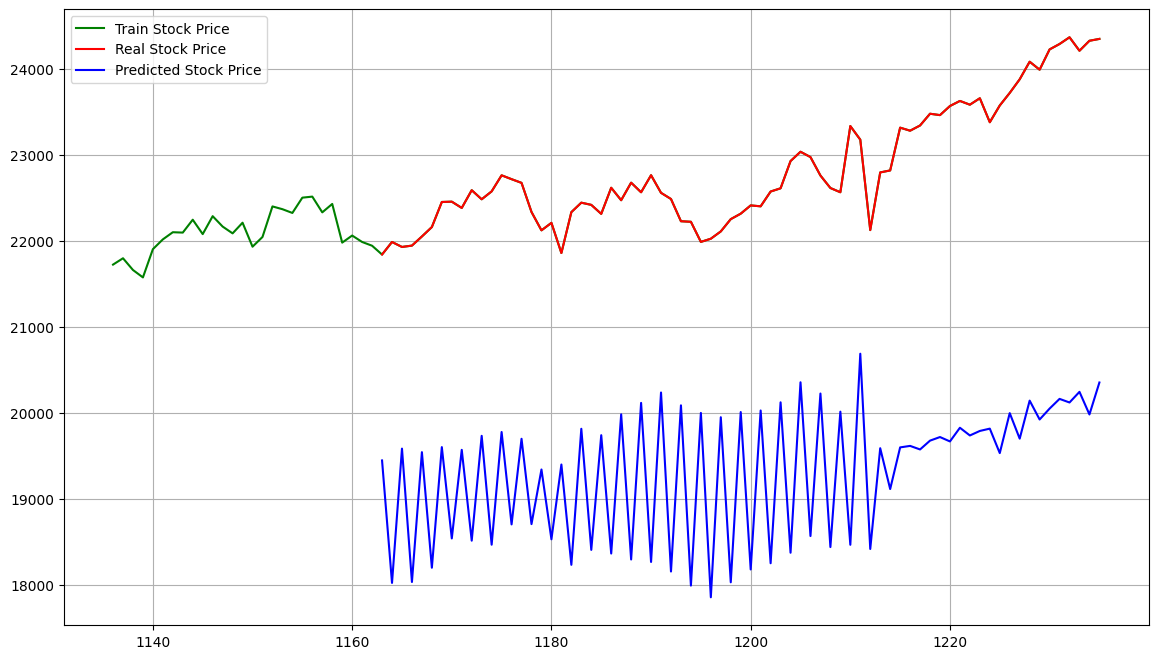

MSE: 12894884.33755777
MAE: 3508.5236566150274
RMSE: 3590.9447694942023


In [55]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Data
train_ma = train_data['Open']
test_ma = test_data['Open']
history = [x for x in train_ma]
y = test_ma
predictions = list()

# Initial model fitting
model = ARIMA(history, order=(0,0,1))
model_fit = model.fit()
yhat = model_fit.forecast(steps=1)  # Forecast one step ahead
predictions.append(yhat[0])
history.append(y.iloc[0])  # Access first element using iloc

# Iterative forecasting
for i in range(1, len(y)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)  # Forecast one step ahead
    predictions.append(yhat[0] + 50)  # Adjust as needed
    obs = y.iloc[i]  # Access element using iloc
    history.append(obs)

# Plotting
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Train Stock Price')
plt.plot(test_data.index, y, color='red', label='Real Stock Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label='Train Stock Price')
plt.plot(test_data.index, y, color='red', label='Real Stock Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
print('MSE: ' + str(mean_squared_error(y, predictions)))
print('MAE: ' + str(mean_absolute_error(y, predictions)))
print('RMSE: ' + str(sqrt(mean_squared_error(y, predictions))))


# ARMA

## Two approaches for stationary.
### 1. Difference.


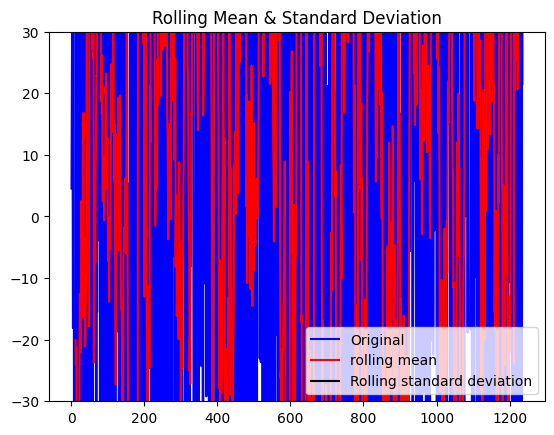

Results of Dickey-Fuller Test:
Test Statistic                -1.657675e+01
p-value                        1.849477e-29
#Lags Used                     3.000000e+00
Number of Observations Used    1.227000e+03
Critical value (1%)           -3.435691e+00
Critical value (5%)           -2.863898e+00
Critical value (10%)          -2.568026e+00
dtype: float64


In [57]:
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim([-30,30])
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
ts_log = data['Open']
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Both mean and variance amplitudes of the data reduced against time axis after difference. Dickey Fuller test showed the data is stationary in 90% confidence level.

### Figuring out p and q in ARMA ( p, q) by Autocorrelation Function and Partial Autocorrelation function.

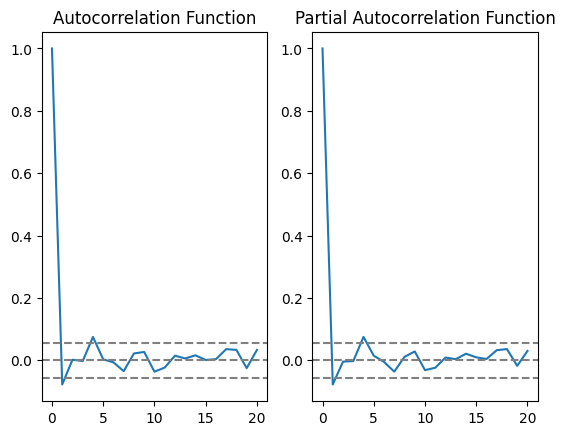

In [58]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

### ARMA process with data after difference:

/home/shubham/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


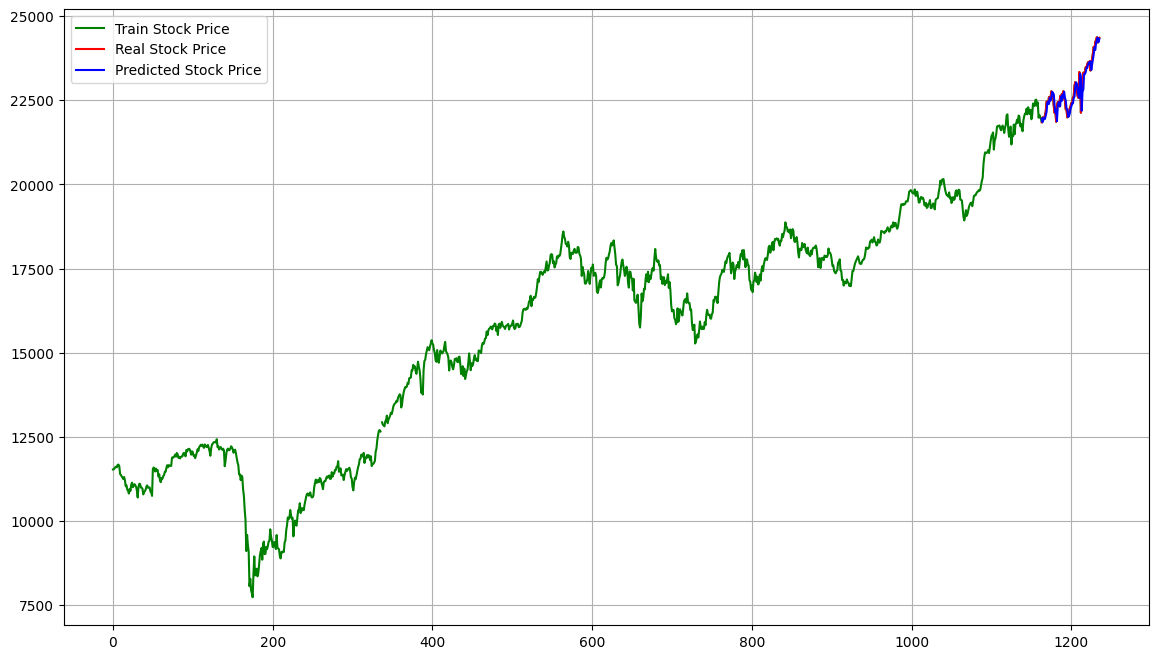

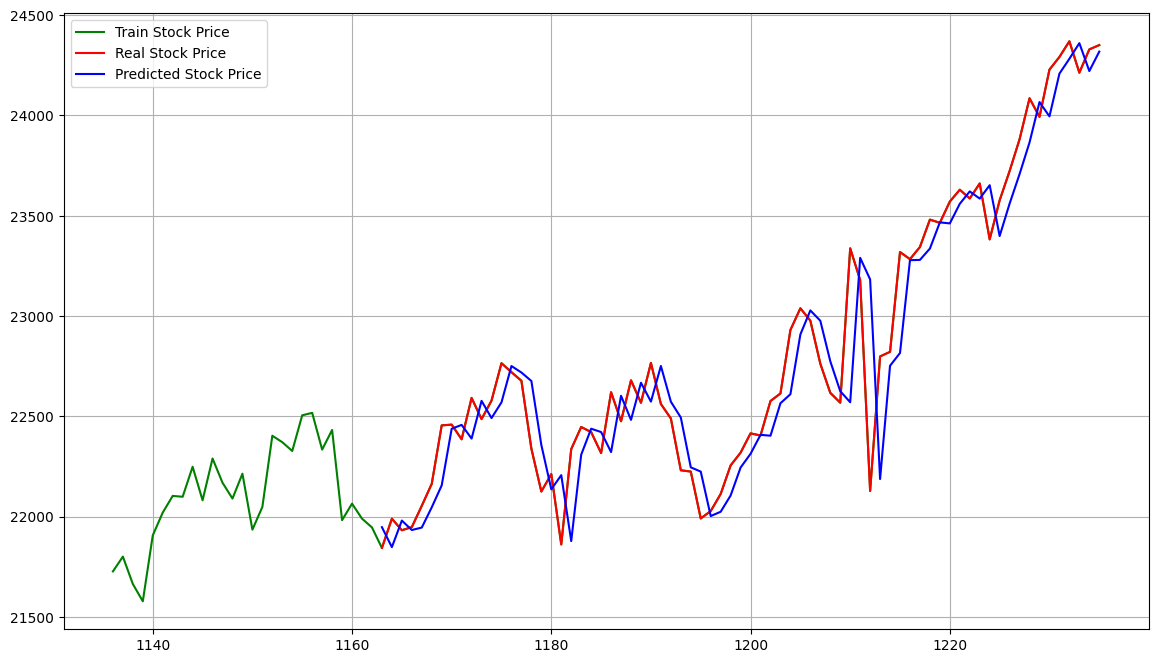

MSE: 56585.9324276155
MAE: 164.06186432292068
RMSE: 237.87797802153838


In [60]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Data
train_arma = train_data['Open']
test_arma = test_data['Open']
history = [x for x in train_arma]
y = test_arma
predictions = list()

# Initial model fitting
model = ARIMA(history, order=(1,0,1))  # ARMA(1,1) equivalent
model_fit = model.fit()
yhat = model_fit.forecast(steps=1)  # Forecast one step ahead
predictions.append(yhat[0])
history.append(y.iloc[0])

# Iterative forecasting
for i in range(1, len(y)):
    model = ARIMA(history, order=(1,0,1))  # ARMA(1,1) equivalent
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)  # Forecast one step ahead
    predictions.append(yhat[0])
    obs = y.iloc[i]  # Access element using iloc
    history.append(obs)

# Plotting
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Open'], color='green', label='Train Stock Price')
plt.plot(test_data.index, y, color='red', label='Real Stock Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label='Train Stock Price')
plt.plot(test_data.index, y, color='red', label='Real Stock Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
print('MSE: ' + str(mean_squared_error(y, predictions)))
print('MAE: ' + str(mean_absolute_error(y, predictions)))
print('RMSE: ' + str(sqrt(mean_squared_error(y, predictions))))


## 2.Seasonal decomposition

In [69]:
data_arima = data['Open']

In [70]:
print(data_arima.isna().sum())
data_arima = data_arima.dropna()
print(data_arima.isna().sum())


2
0


<Figure size 1850x1050 with 0 Axes>

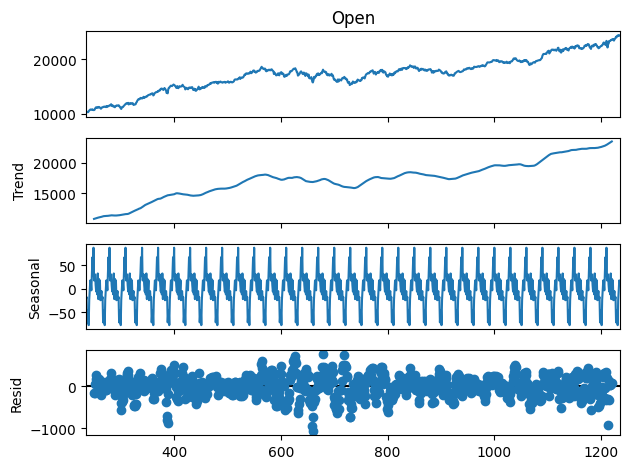

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_arima[-1000:], model='additive', period=30)

# Plot the decomposition
fig = plt.figure(figsize=(18.5, 10.5))
fig = decomposition.plot()
plt.show()


### Separate original data into three parts as shown in illustration. Residual is the rest of data which can be used in the model. It is stationary data after eliminating the other two parts.


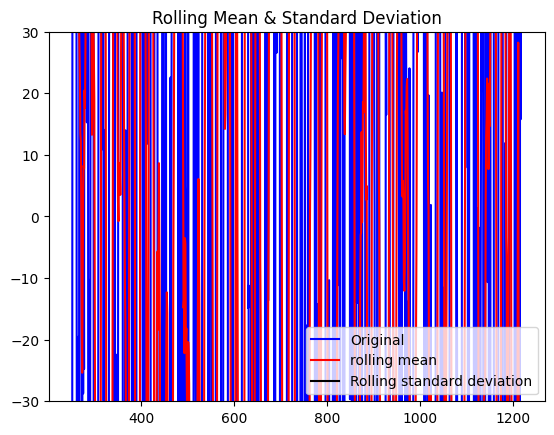

Results of Dickey-Fuller Test:
Test Statistic                -1.165036e+01
p-value                        2.044313e-21
#Lags Used                     9.000000e+00
Number of Observations Used    9.600000e+02
Critical value (1%)           -3.437180e+00
Critical value (5%)           -2.864555e+00
Critical value (10%)          -2.568376e+00
dtype: float64


In [76]:
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim([-30,30])
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
residual = decomposition.resid
residual.dropna(inplace=True)
test_stationarity(residual)

### As shown in the charts, mean and variance have low volatility. And Dickey Fuller test showed the data is stationary in 99% confidence level.

### ARMA process with data with seasonal decomposition

In [77]:
trend = decomposition.trend
sea=decomposition.seasonal

In [78]:
train_trend, test_trend = trend[0:-73], trend[-73:]
train_sea, test_sea = sea[0:-73], sea[-73:]

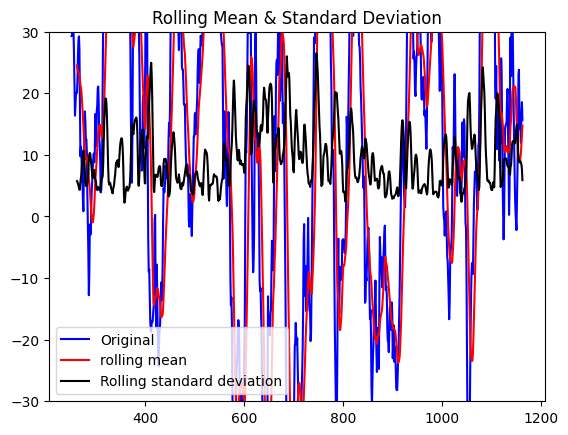

Results of Dickey-Fuller Test:
Test Statistic                -5.702816e+00
p-value                        7.606790e-07
#Lags Used                     2.100000e+01
Number of Observations Used    8.890000e+02
Critical value (1%)           -3.437727e+00
Critical value (5%)           -2.864797e+00
Critical value (10%)          -2.568504e+00
dtype: float64


In [79]:
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim([-30,30])
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
ts_log = train_trend
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

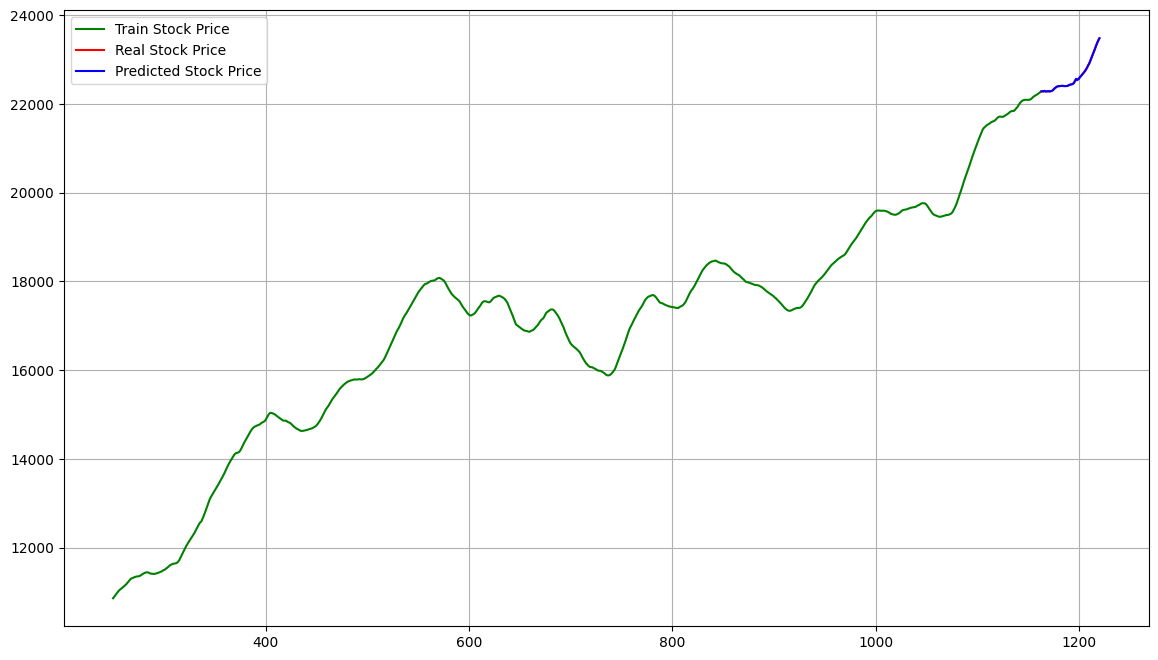

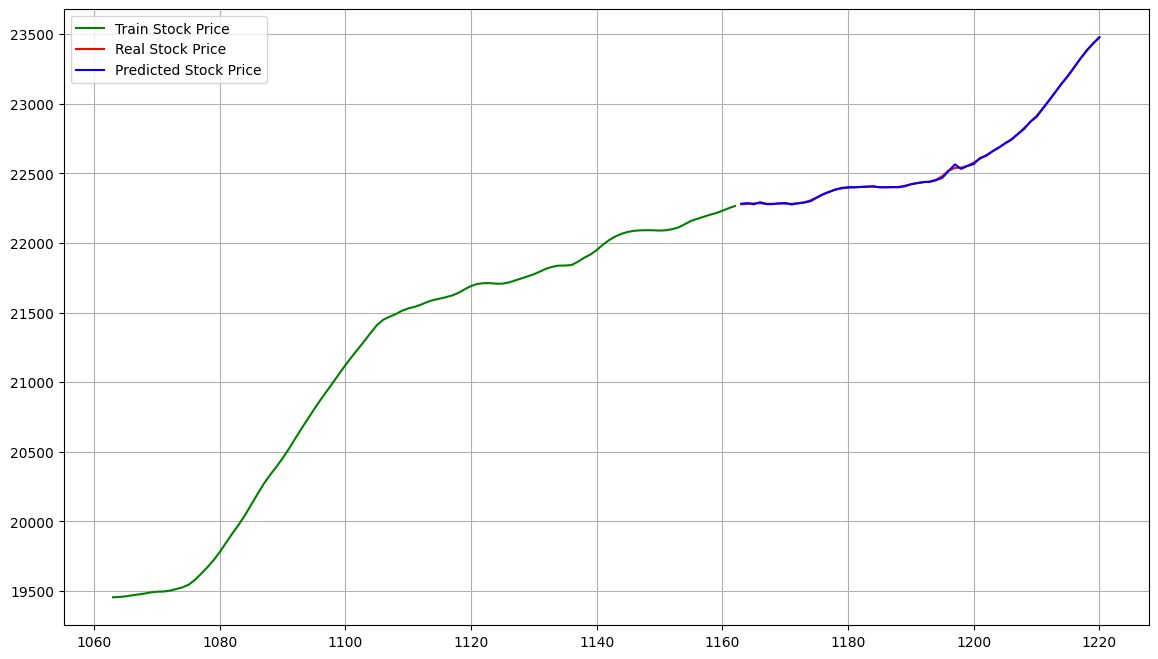

MSE: 26.391876523398512
MAE: 3.437545044963717
RMSE: 5.137302455900228


In [84]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Prepare data
train_arima = train_trend.dropna()
test_arima = test_trend.dropna()
history = [x for x in train_arima]
y = test_arima
predictions = []

# Initial model fitting
model = ARIMA(history, order=(2,1,2))
model_fit = model.fit()  # Removed disp=0
yhat = model_fit.forecast(steps=1)[0]
predictions.append(yhat)  # Adjust with test_sea[0] if needed
history.append(y.iloc[0])

# Iterative forecasting
for i in range(1, len(y)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()  # Removed disp=0
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)  # Adjust with test_sea[i] if needed
    obs = y.iloc[i]
    history.append(obs)

# Plotting
plt.figure(figsize=(14,8))
plt.plot(train_arima.index, train_arima, color='green', label='Train Stock Price')
plt.plot(y.index, y, color='red', label='Real Stock Price')
plt.plot(y.index, predictions, color='blue', label='Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(train_arima.index[-100:], train_arima.tail(100), color='green', label='Train Stock Price')
plt.plot(y.index[-73:], y.tail(73), color='red', label='Real Stock Price')
plt.plot(y.index, predictions, color='blue', label='Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
print('MSE: ' + str(mean_squared_error(y, predictions)))
print('MAE: ' + str(mean_absolute_error(y, predictions)))
print('RMSE: ' + str(sqrt(mean_squared_error(y, predictions))))


# ARMA-GARCH

In [85]:
returns = pd.DataFrame(np.log(train_data['Open']).diff().dropna())
returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)

In [86]:
from statsmodels.tsa.stattools import adfuller
returns_array_like = [x for l in returns.values for x in l]
_, pvalue, *_ = adfuller(returns_array_like)
print ('pvalue :',pvalue)

pvalue : 1.895478902754379e-17


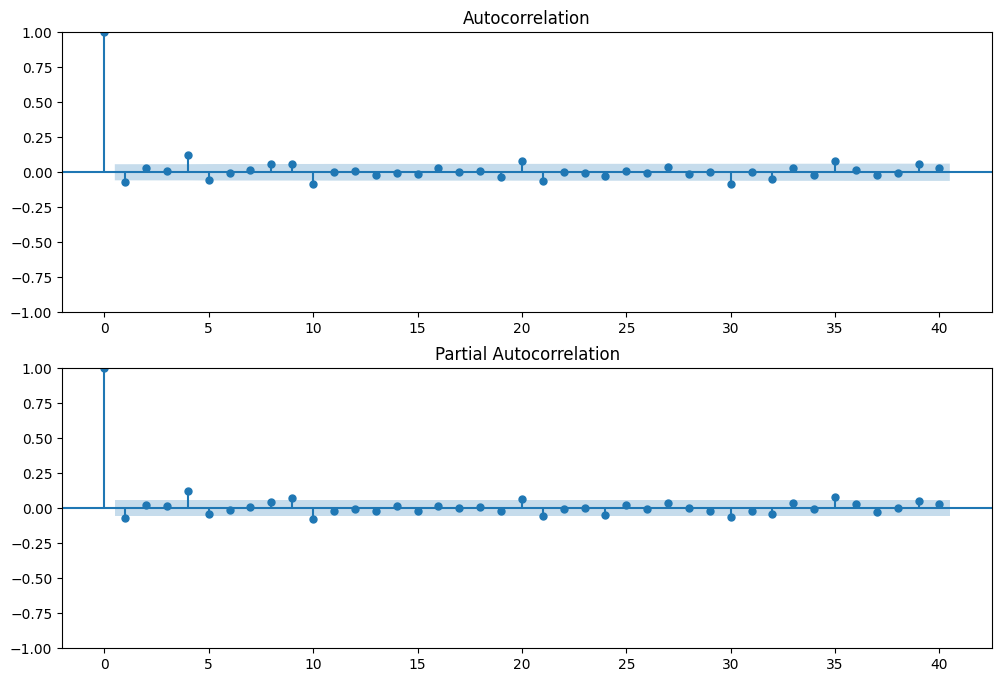

In [87]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returns.values, lags=40, alpha=0.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(returns.values, lags=40, alpha=0.05, ax=ax2)

In [93]:
import statsmodels.tsa.stattools as sts

# Calculate ARMA model orders using information criteria
resid = sts.arma_order_select_ic(
    returns,  # Your time series data
    max_ar=4,  # Maximum order for AR component
    max_ma=4,  # Maximum order for MA component
    ic=['aic', 'bic', 'hqic'],  # Information criteria to use
    trend='n',  # No constant term
    fit_kw=dict(method='css')  # Fit method (conditional sum of squares)
)

# Print results for each criterion
print('AIC-order: {}'.format(resid.aic_min_order))
print('BIC-order: {}'.format(resid.bic_min_order))
print('HQIC-order: {}'.format(resid.hqic_min_order))


AIC-order: (0, 0)
BIC-order: (0, 0)
HQIC-order: (0, 0)


In [96]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARMA model using ARIMA with d=0
arma_mod01 = ARIMA(returns, order=(1, 0, 0)).fit()

# Print the summary of the ARMA model
print(arma_mod01.summary())

# Print the model parameters
print('-------------------------------------')
print(arma_mod01.params)



                               SARIMAX Results                                
Dep. Variable:        Log Return Rate   No. Observations:                 1158
Model:                 ARIMA(1, 0, 0)   Log Likelihood                3434.566
Date:                Tue, 23 Jul 2024   AIC                          -6863.131
Time:                        20:31:05   BIC                          -6847.968
Sample:                             0   HQIC                         -6857.409
                               - 1158                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.514      0.130      -0.000       0.001
ar.L1         -0.0692      0.014     -4.771      0.000      -0.098      -0.041
sigma2         0.0002   2.26e-06     68.645      0.0

/home/shubham/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/shubham/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/shubham/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### autocorrelation test on the residuals

In [100]:
from statsmodels.stats import diagnostic

# Obtain the residuals from the fitted model
resid = arma_mod01.resid

# Perform Ljung-Box and Box-Pierce tests
lb_test, lb_pvalue, _, bp_pvalue = diagnostic.acorr_ljungbox(resid, lags=None, boxpierce=True)

# Print p-values from both tests
print("Ljung-Box test p-values:", lb_pvalue)
print("Box-Pierce test p-values:", bp_pvalue)


Ljung-Box test p-values: lb_pvalue
Box-Pierce test p-values: bp_pvalue


### test ARCH effect on the residuals

In [101]:
*_, fpvalue = diagnostic.het_arch(resid)
print (fpvalue)

1.9666776049902106e-53


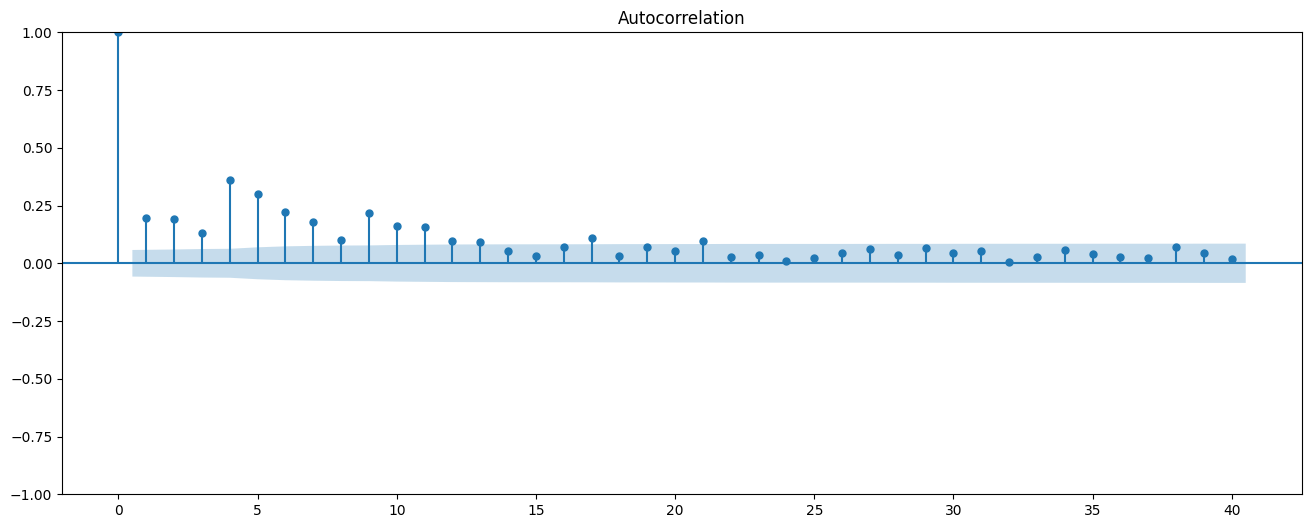

In [102]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(resid.values ** 2, lags=40, ax=ax1)

In [103]:
from statsmodels.stats.stattools import jarque_bera
_, jbpv, *_ = jarque_bera(returns.values)
print ('pvalue-->',jbpv)

pvalue--> [0.]


In [104]:
from arch import arch_model
from arch.univariate import ZeroMean, GARCH, StudentsT, ConstantMean

In [105]:
arch_mod = ConstantMean(returns)
arch_mod.volatility = GARCH(1,0,1)
arch_mod.distribution = StudentsT()
res=arch_mod.fit(update_freq=5, disp='off')
print (res.summary())
print (' ')
print ('The estimated parameters: ')
print ('----------------------------------------')
print (res.params)

                        Constant Mean - GARCH Model Results                         
Dep. Variable:              Log Return Rate   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2815.40
Distribution:      Standardized Student's t   AIC:                          -5620.80
Method:                  Maximum Likelihood   BIC:                          -5595.53
                                              No. Observations:                 1158
Date:                      Tue, Jul 23 2024   Df Residuals:                     1157
Time:                              20:32:49   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

/home/shubham/.local/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001561. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# $\begin{eqnarray} r_t & = & \mu + \epsilon_t + \theta\epsilon_{t-1} \\ \epsilon_t & = & \sigma_t e_t \\ \sigma^2_t & = & \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma^2_{t-1} \end{eqnarray}$

In [106]:
mu = arma_mod01.params[0]
theta = arma_mod01.params[1]
omega = res.params[1]
alpha = res.params[2]
beta = res.params[3]
print(mu, theta, omega, alpha, beta)

0.000534826115719856 -0.06915482419300938 0.00040670021366908456 0.3651937736536933 0.6290273242691795


In [107]:
sigma_t = res.conditional_volatility.iloc[-1]
sigma_forecast = np.sqrt(omega + alpha * res.resid.iloc[-1] ** 2 + beta * res.conditional_volatility.iloc[-1] ** 2)
epsilon_t = sigma_t * np.random.standard_normal()
epsilon_forecast = sigma_forecast * np.random.standard_normal()
returns_forecast = mu + epsilon_forecast + theta * epsilon_t
returns_forecast

-0.07015849017125261

In [108]:
def returns_predict(period):
    returns_pool = []
    for i in range(period):
        sigma_t = res.conditional_volatility.iloc[-1]
        epsilon_t = sigma_t * np.random.standard_normal()
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)
        epsilon_forecast = sigma_forecast * np.random.standard_normal()
        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        returns_pool.append(returns_forecast)
        sigma_t = sigma_forecast
    return returns_pool

In [109]:
train_returns = pd.DataFrame(np.log(test_data['Open']).diff().dropna())
train_returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)

### Prediction results of the ARMA-GARCH model

<Figure size 1400x800 with 0 Axes>

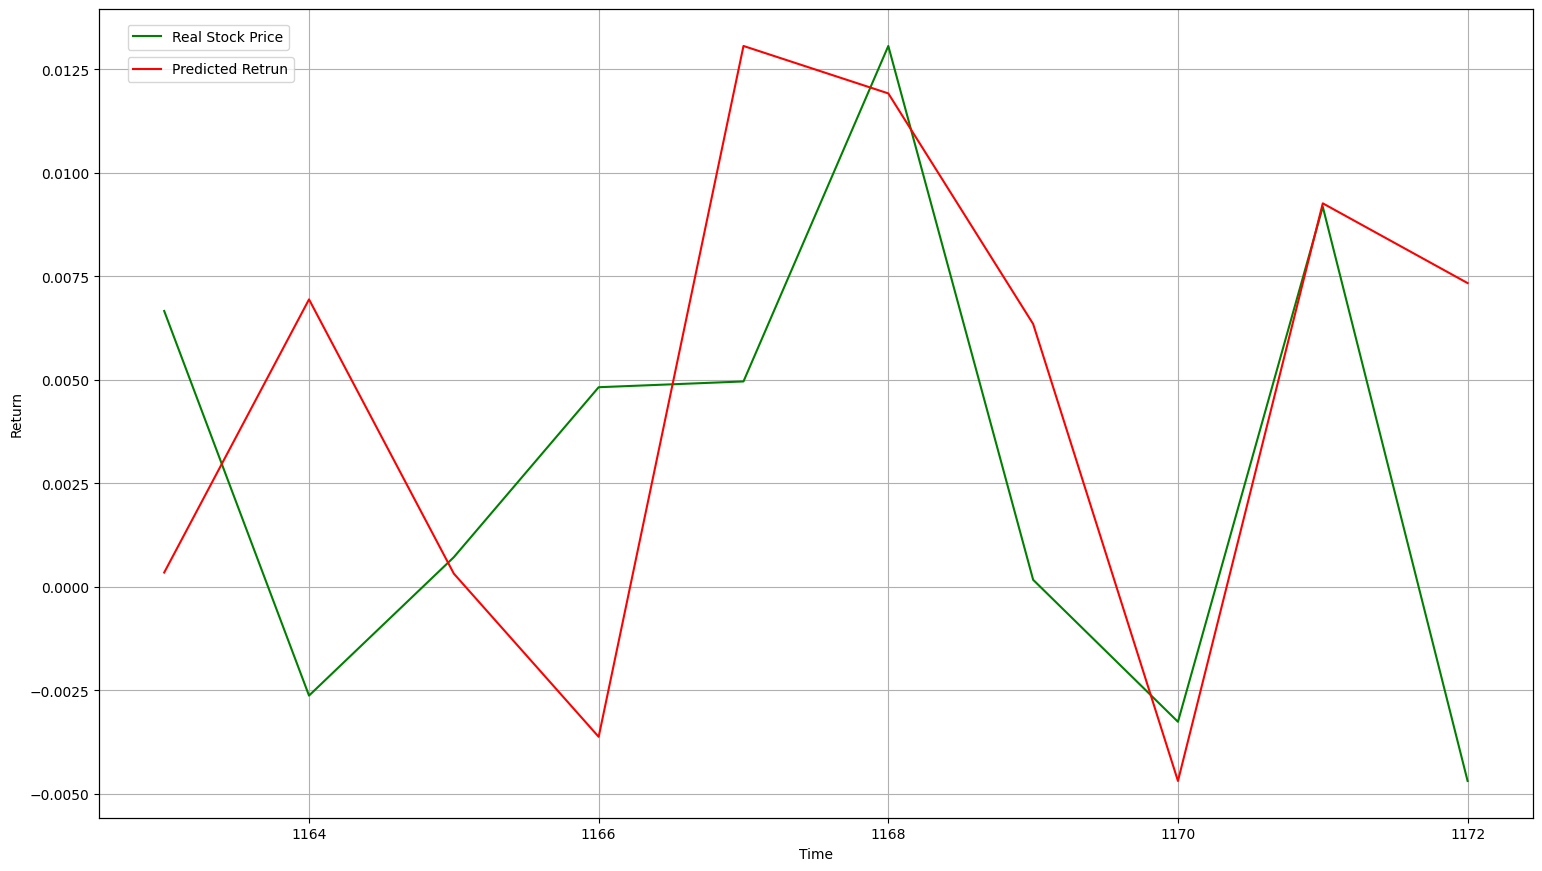

In [110]:
plt.figure(figsize=(14,8))
fig = plt.figure()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111)
ax.plot(data.index[-73:-63], train_returns['Log Return Rate'][:10], color='green', label = 'Real Stock Price')
ax2 = ax.twinx()
ax2.plot(data.index[-73:-63],returns_predict(10), color='red',label = 'Predicted Retrun')
ax.legend(loc = (0.02, 0.95))
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Return")
ax2.set_yticks([])
ax2.legend(loc = (0.02, 0.91))

                    Open          High           Low         Close   
Date                                                                 
2019-07-09  11531.599609  11582.549805  11461.000000  11555.900391  \
2019-07-10  11536.150391  11593.700195  11475.650391  11498.900391   
2019-07-11  11561.450195  11599.000000  11519.500000  11582.900391   
2019-07-12  11601.150391  11639.549805  11538.599609  11552.500000   
2019-07-15  11614.750000  11618.400391  11532.299805  11588.349609   

               Adj Close    Volume  
Date                                
2019-07-09  11555.900391  442500.0  
2019-07-10  11498.900391  337600.0  
2019-07-11  11582.900391  317300.0  
2019-07-12  11552.500000  359400.0  
2019-07-15  11588.349609  368800.0  


/home/shubham/.local/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001473. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

KeyboardInterrupt



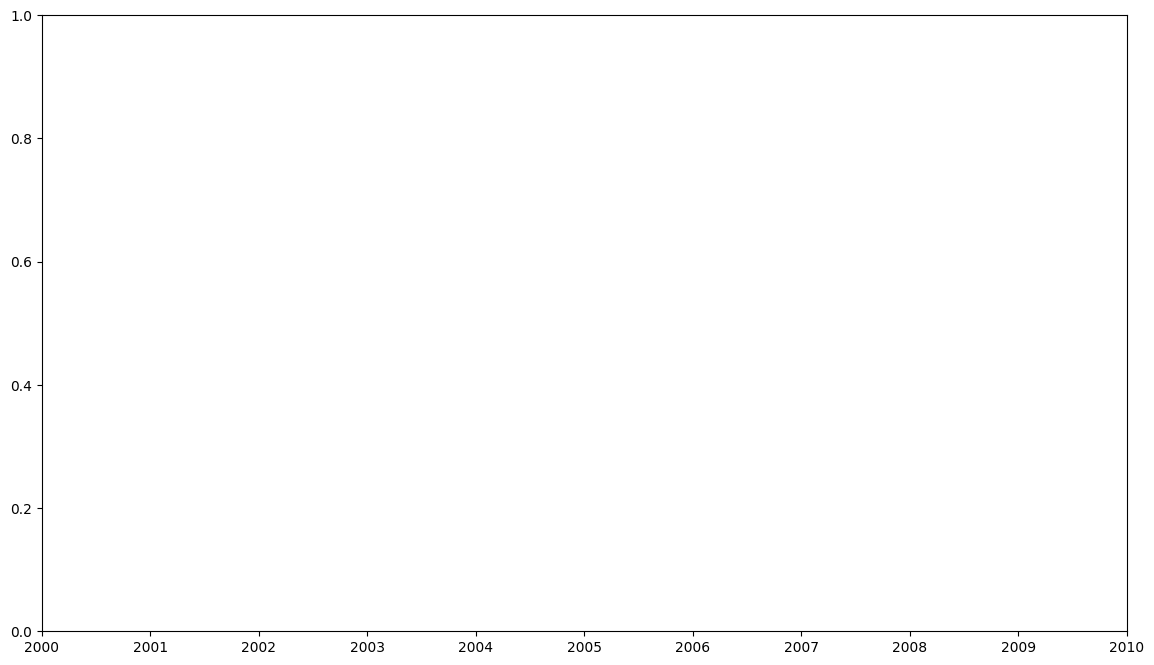

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# Load Nifty 50 data (replace with your actual data file path)
data = pd.read_csv('/home/shubham/Desktop/NIFTY-Share-Market-Price-Prediction/data/NIFTY 50.csv', parse_dates=['Date'], index_col='Date')
print(data.head())
data['Returns'] = data['Close'].pct_change().dropna()

# Drop missing values
returns = data['Returns'].dropna()

# Fit GARCH model
model = arch_model(returns, vol='Garch', p=1, q=1)
model_fit = model.fit(disp="off")

# Forecast volatility
forecast_steps = 30  # Forecasting the next 30 periods
forecast = model_fit.forecast(start=0, horizon=forecast_steps)

# Extract forecasted volatility
forecasted_volatility = np.sqrt(forecast.variance.values[-forecast_steps:]).flatten()

# Create date range for forecast
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Realized volatility (Conditional volatility)
realized_volatility = np.sqrt(model_fit.conditional_volatility)

# Plotting
plt.figure(figsize=(14,8))

# Plot realized volatility (limited to the range of forecast)
plt.plot(data.index[1:], np.sqrt(data['Returns'].var()), color='red', label='Realized Volatility')

# Plot forecasted volatility
plt.plot(forecast_index, forecasted_volatility, color='blue', label='Forecasted Volatility')

plt.legend()
plt.grid(True)
plt.title('GARCH Model Forecasted vs Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()